Import backtester

In [57]:
import importlib.util
import sys
import os

# Path to backtester.py
backtester_path = "backtester.py"
spec = importlib.util.spec_from_file_location("backtester", backtester_path)
backtester = importlib.util.module_from_spec(spec)
sys.modules["backtester"] = backtester
spec.loader.exec_module(backtester)

Code:

In [58]:
import numpy as np
from sklearn.decomposition import PCA
import optuna

LOOKBACK_WINDOW = 200
Z_ENTRY = 1.5
INSTRUMENT_POSITION_LIMIT = 10000

model_state = {}

def compute_zscore(spread):
    mean = np.mean(spread)
    std = np.std(spread)
    return (spread - mean) / (std + 1e-6)

def get_pca_residual(p1, p2):
    X = np.vstack([p1, p2]).T
    pca = PCA(n_components=1)
    principal = pca.fit_transform(X)
    reconstructed = pca.inverse_transform(principal)
    residual = X - reconstructed
    return residual[:, 0] - residual[:, 1]



def getMyPosition(prcSoFar):
    global model_state
    if prcSoFar.shape[1] == LOOKBACK_WINDOW + 10:  # Just on first valid call
        model_state = {
            "last_trained": -RETRAIN_INTERVAL,
            "top_pairs": [],
            "pca_model": None
        }
    n_assets, n_days = prcSoFar.shape
    positions = np.zeros(n_assets)

    if n_days < LOOKBACK_WINDOW + 10:
        return positions

    # Retrain every interval
    if n_days - model_state["last_trained"] >= RETRAIN_INTERVAL:
        model_state["last_trained"] = n_days

        # Compute rolling correlations
        returns = np.diff(np.log(prcSoFar[:, -LOOKBACK_WINDOW:]), axis=1)
        cor_matrix = np.corrcoef(returns)
        pairs = [((i, j), abs(cor_matrix[i, j])) for i in range(n_assets) for j in range(i+1, n_assets)]
        top_pairs = sorted(pairs, key=lambda x: -x[1])[:10]
        model_state["top_pairs"] = [pair for pair, _ in top_pairs]

        # Fit PCA to all asset prices
        X = prcSoFar[:, -LOOKBACK_WINDOW:].T
        model_state["pca_model"] = PCA(n_components=1).fit(X)

    # Trade signals for top pairs
    for i, j in model_state["top_pairs"]:
        p1, p2 = prcSoFar[i, -LOOKBACK_WINDOW:], prcSoFar[j, -LOOKBACK_WINDOW:]
        spread = p1 - p2
        z = compute_zscore(spread)

        # PCA residual
        residual = get_pca_residual(p1, p2)
        r_z = compute_zscore(residual)

        # Hybrid signal: combine spread z-score and PCA residual z-score
        hybrid_signal = z[-1] + r_z[-1]

        # Position sizing inversely proportional to volatility
        volatility = np.std(spread)
        capital = 2000 / (volatility + 1e-6)

        if hybrid_signal > Z_ENTRY:
            positions[i] -= capital / prcSoFar[i, -1]
            positions[j] += capital / prcSoFar[j, -1]
        elif hybrid_signal < -Z_ENTRY:
            positions[i] += capital / prcSoFar[i, -1]
            positions[j] -= capital / prcSoFar[j, -1]

    # Enforce position limits
    pos_limit = INSTRUMENT_POSITION_LIMIT / prcSoFar[:, -1]
    return np.clip(positions, -pos_limit, pos_limit)


Run backtester

c:\Users\tavis\.vscode\algothon2025\backtester.py:386: RuntimeWarning: invalid value encountered in divide
  sharpe_ratios: ndarray = (means / stds) * np.sqrt(250)


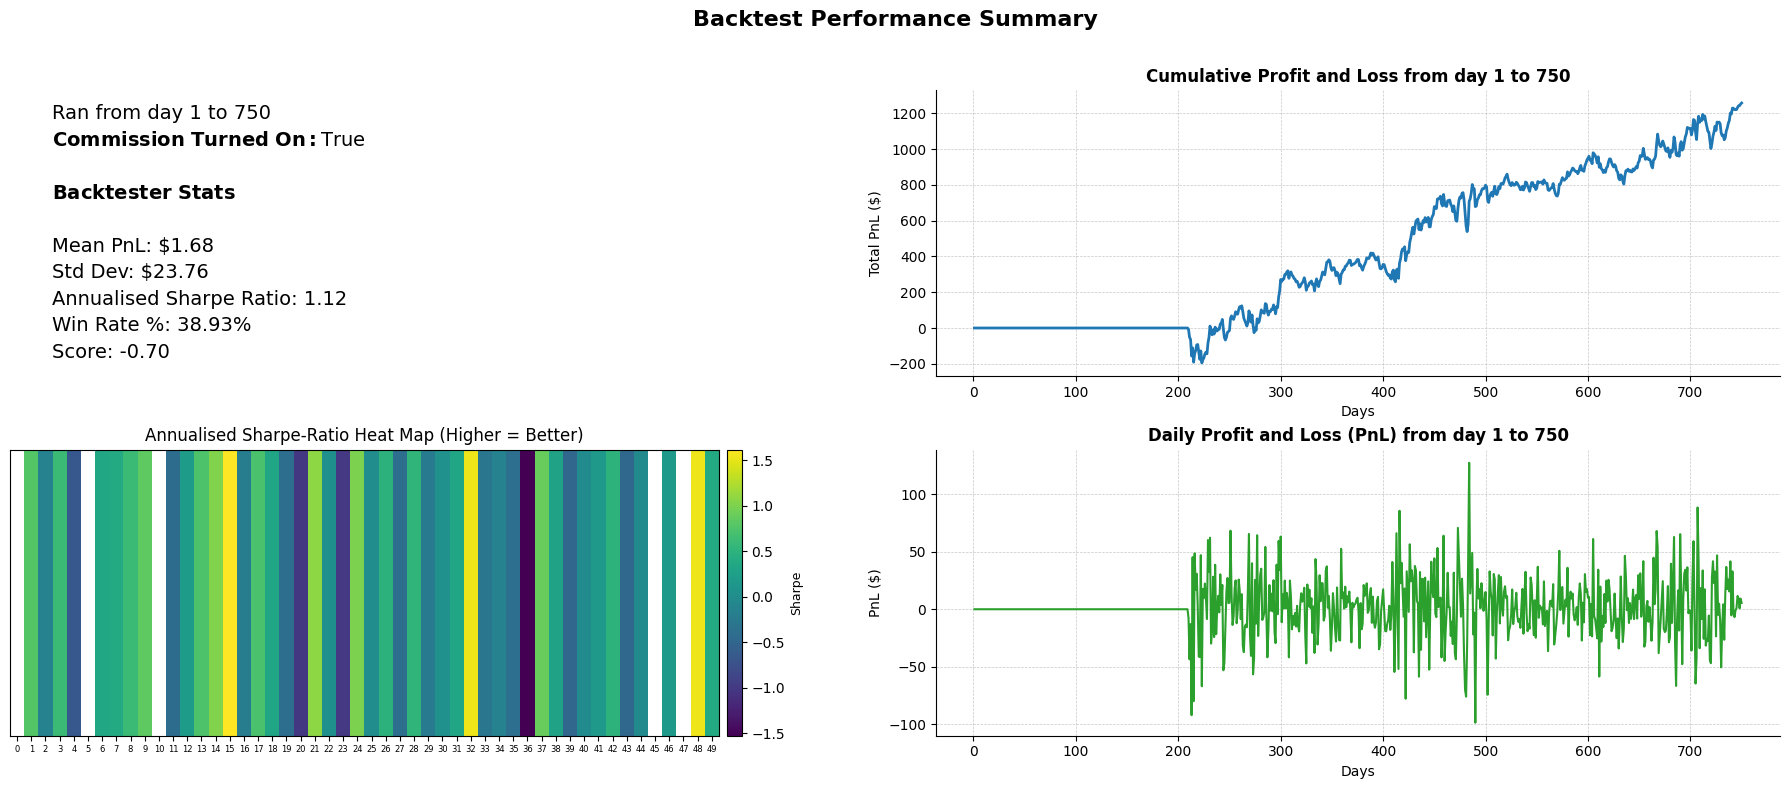

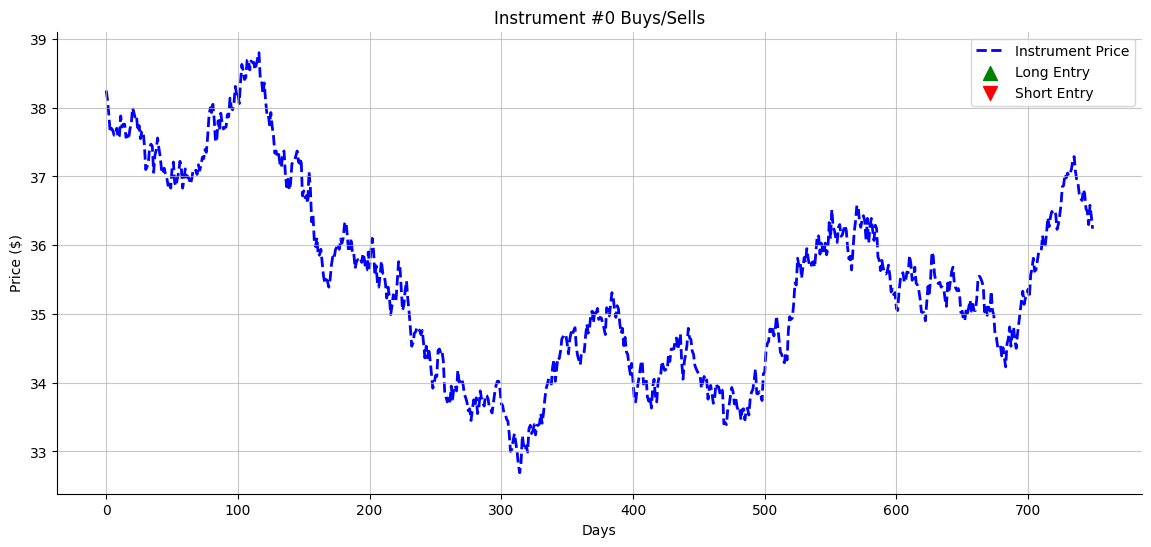

In [59]:
params = backtester.Params(
    strategy_function=getMyPosition,
    start_day=1,
    end_day=750,
    enable_commission=True,
    graphs=["cum-pnl", "sharpe-heat-map", "daily-pnl"]
)

bt = backtester.Backtester(params)
results = bt.run(start_day=1, end_day=750)
bt.show_dashboard(results, graphs=params.graphs)
bt.show_price_entries(results)